In [1]:
from datasets import load_dataset, Audio, DatasetDict, Dataset, load_from_disk, IterableDatasetDict, interleave_datasets, concatenate_datasets

from transformers import WhisperModel, WhisperFeatureExtractor, WhisperProcessor, WhisperForConditionalGeneration, GenerationConfig, WhisperTokenizer, logging, BitsAndBytesConfig, Seq2SeqTrainingArguments, Seq2SeqTrainer, TrainerCallback, TrainingArguments, TrainerState, TrainerControl
from transformers.trainer_utils import PREFIX_CHECKPOINT_DIR
# from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel, LoraModel, LoraConfig, get_peft_model
from huggingface_hub import notebook_login, create_repo
from transformers.models.whisper.english_normalizer import BasicTextNormalizer

import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union
import multiprocess as mp
import gc
import time
import numpy as np
# import noisereduce as nr
from scipy import signal
import librosa
import evaluate
import jiwer
import os
import numba
import json
from numba import jit, cuda

import torch
import torch.nn.functional as F
import math
import matplotlib.pyplot as plt
import torchaudio
from torch.nn import ZeroPad2d

from torch.utils.data import Dataset, DataLoader


In [2]:
from model import Processor, SpectroDataset, SpectrogramEncoder, UNetDecoder, STSAutoEncoder
from losses import MCDLoss, PerceptualLoss, ContrastiveLoss, AutoencoderLoss
from evaluation import Evaluator

In [3]:
sampling_rate = 16000
os.environ['KMP_DUPLICATE_LIB_OK']='True'
logging.set_verbosity_warning()
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(torch.version.cuda)

Using device: cuda
12.4


In [4]:
# notebook_login()

In [5]:
import nemo.collections.asr as nemo_asr
from nemo.collections.asr.models import EncDecRNNTModel

# asr_model_id = "nvidia/stt_it_conformer_transducer_large"
asr_model_id = "nvidia/stt_en_conformer_transducer_large"

asr_model = nemo_asr.models.EncDecRNNTBPEModel.from_pretrained(asr_model_id)
asr_model.cfg.joint['fuse_loss_wer'] = False
# asr_model.cfg.loss["max_logit_len"] = 150

asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)

asr_model.to(device)

[NeMo I 2025-05-03 13:05:19 mixins:181] Tokenizer SentencePieceTokenizer initialized with 1024 tokens


[NeMo W 2025-05-03 13:05:20 modelPT:180] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    manifest_filepath:
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket1/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket2/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket3/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket4/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket5/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket6/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket7/tarred_audio_manifest.json
    - - /data/NeMo_ASR_SET/English/v3.0/train_bucketed/bucket8/tarred_audio_manifest.json
    sample_rate: 16000
    

[NeMo I 2025-05-03 13:05:20 features:305] PADDING: 0
[NeMo I 2025-05-03 13:05:22 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}
[NeMo I 2025-05-03 13:05:22 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-05-03 13:05:22 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-05-03 13:05:22 rnnt_models:226] Using RNNT Loss : warprnnt_numba
    Loss warprnnt_numba_kwargs: {'fastemit_lambda': 0.0, 'clamp': -1.0}


[NeMo W 2025-05-03 13:05:22 rnnt_loop_labels_computer:289] No conditional node support for Cuda.
    Cuda graphs with while loops are disabled, decoding speed will be slower
    Reason: No `cuda-python` module. Please do `pip install cuda-python>=12.3`


[NeMo I 2025-05-03 13:05:23 save_restore_connector:275] Model EncDecRNNTBPEModel was successfully restored from /root/.cache/huggingface/hub/models--nvidia--stt_en_conformer_transducer_large/snapshots/a40623d1796368b64a9433bce3bcd75fce379a7b/stt_en_conformer_transducer_large.nemo.


EncDecRNNTBPEModel(
  (preprocessor): AudioToMelSpectrogramPreprocessor(
    (featurizer): FilterbankFeatures()
  )
  (encoder): ConformerEncoder(
    (pre_encode): ConvSubsampling(
      (out): Linear(in_features=10240, out_features=512, bias=True)
      (conv): Sequential(
        (0): Conv2d(1, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (3): ReLU(inplace=True)
      )
    )
    (pos_enc): RelPositionalEncoding(
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (layers): ModuleList(
      (0-16): 17 x ConformerLayer(
        (norm_feed_forward1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feed_forward1): ConformerFeedForward(
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (activation): Swish()
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048,

In [6]:
# import nemo.collections.asr as nemo_asr
# from nemo.collections.asr.models import EncDecMultiTaskModel

# asr_model_id = "nvidia/canary-1b"

# asr_model = nemo_asr.models.EncDecMultiTaskModel.from_pretrained(asr_model_id)
# # asr_model.cfg.joint['fuse_loss_wer'] = False
# # asr_model.cfg.loss["max_logit_len"] = 150

# asr_model.joint = EncDecRNNTModel.from_config_dict(asr_model.cfg.joint)

# asr_model.to(device)

In [7]:
from model import Processor

processor = Processor(asr_model,device)

In [8]:
from lie import localized_smooth_field_1d, localized_smooth_field_2d, generate_lie_generator_fields, apply_transformation


In [9]:
import torch.nn.functional as F

def pad_spectrogram(spec, target_height=96):
    """
    Pads a spectrogram [B, 1, F, T] to height=96 (bottom-padding).
    """
    pad_height = target_height - spec.shape[2]
    return F.pad(spec, (0, 0, 0, pad_height))  # pad = (left, right, top, bottom)

def imagenet_normalize_1ch(spec):
    """
    Normalize a 1-channel [B, 1, F, T] spectrogram using ImageNet stats
    (broadcasting mean/std of grayscale version)
    """
    mean = 0.485
    std = 0.229
    return (spec - mean) / std


def normalize_spectrogram(S, min_val=-7.0, max_val=1.0):
    """
    Normalize log-Mel spectrogram from [min_val, max_val] to [0, 1]
    Input: Tensor [F, T]
    Output: Tensor [F, T]
    """
    return (S - min_val) / (max_val - min_val)

def denormalize_spectrogram(S_norm, min_val=-7.0, max_val=1.0):
    return S_norm * (max_val - min_val) + min_val


In [10]:
# field_normalization_ranges = {
#     't_stretch': 0.15,     # Approx max absolute value
#     'f_stretch': 0.15,
#     'warp_2d_v': 0.2,
#     'warp_2d_w': 0.2,
#     'amplitude': 0.3
# }


def normalize_field(field, max_abs):
    """
    Normalize a field from [-max_abs, +max_abs] → [-1, 1]
    """
    return torch.clamp(field / max_abs, min=-1.0, max=1.0)

def denormalize_field(norm_field, max_abs):
    return norm_field * max_abs



def normalize_fields(fields, norm_ranges):
    normed_fields = {}
    for key, value in fields.items():
        if key == 'warp_2d':
            v, w = value
            v_norm = normalize_field(v, norm_ranges['warp_2d'])
            w_norm = normalize_field(w, norm_ranges['warp_2d'])
            normed_fields[key] = (v_norm, w_norm)
        else:
            normed_fields[key] = normalize_field(value, norm_ranges[key])
    return normed_fields

def denormalize_fields(normed_fields, norm_ranges):
    denormed = {}
    for key, value in normed_fields.items():
        if key == 'warp_2d':
            v_norm, w_norm = value
            v = denormalize_field(v_norm, norm_ranges['warp_2d'])
            w = denormalize_field(w_norm, norm_ranges['warp_2d'])
            denormed[key] = (v, w)
        else:
            denormed[key] = denormalize_field(value, norm_ranges[key])
    return denormed


In [11]:
import segmentation_models_pytorch as smp
import torch.nn as nn

class LieFieldPredictor(nn.Module):
    def __init__(self, encoder_name='efficientnet-b0', pretrained=True, in_channels=1, out_channels=5):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name=encoder_name,
            encoder_weights='imagenet' if pretrained else None,
            in_channels=in_channels,
            classes=out_channels,
            activation=None  # No activation here — leave that to post-processing if needed
        )

    def forward(self, x):
        """
        Input: x of shape [B, 1, F, T] (e.g. [B, 1, 80, 512])
        Output: y of shape [B, 5, F, T] — one field per channel
        """
        return self.unet(x)


In [12]:
def apply_inverse_transform(S_distorted, pred_fields, epsilon_dict=None):
    """
    Applies the inverse transformation based on predicted Lie generator fields.

    Args:
        S_distorted: Tensor of shape [B, 1, F, T] — normalized distorted spectrogram
        pred_fields: Tensor of shape [B, 5, F, T] — predicted normalized Lie fields
        epsilon_dict: dict mapping each field to max ε (needed to rescale from [-1, 1])

    Returns:
        S_recon: Tensor of shape [B, 1, F, T] — spectrogram after inverse warp
    """

    B, C, F, T = pred_fields.shape
    device = pred_fields.device
    S_recon = S_distorted.clone()

    # print("apply_inverse_transform: S_distorted",S_distorted.shape)

    # Unnormalize fields back to real ε ranges
    if epsilon_dict is None:
        epsilon_dict = {
            't_stretch': 0.1,
            'f_stretch': 0.2,
            'warp_2d': 0.2,
            'amplitude': 0.05,
            'phase': 0.1,
        }

    # Denormalize predicted fields from [-1, 1] to [-ε, +ε]
    t_stretch = pred_fields[:, 0] * epsilon_dict['t_stretch']
    f_stretch = pred_fields[:, 1] * epsilon_dict['f_stretch']
    warp_v    = pred_fields[:, 2] * epsilon_dict['warp_2d']
    warp_w    = pred_fields[:, 3] * epsilon_dict['warp_2d']
    amplitude = pred_fields[:, 4] * epsilon_dict['amplitude']
    amplitude = amplitude.unsqueeze(1) # Add channel dim

    S_recon = batch_grid_warp(S_recon, -t_stretch, -f_stretch)
    S_recon = batch_grid_warp(S_recon, -warp_v, -warp_w)
    S_recon = S_recon / (1.0 + amplitude).clamp(min=0.5)  # Safe division


    return S_recon, (t_stretch,f_stretch,warp_v,warp_w,amplitude)



def batch_grid_warp(spectrogram, delta_t, delta_f):
    """
    Applies a batched 2D warp using delta_t and delta_f.

    Args:
        spectrogram: [B, 1, F, T]
        delta_t: [B, F, T] — time axis deformation
        delta_f: [B, F, T] — freq axis deformation

    Returns:
        Warped spectrogram [B, 1, F, T]
    """
    B, _, F_bins, T_steps = spectrogram.shape
    # print("batch_grid_warp: spectrogram",spectrogram.shape)
    device = spectrogram.device

    # Coordinate grid
    t_coords = torch.linspace(-1, 1, T_steps, device=device)
    f_coords = torch.linspace(-1, 1, F_bins, device=device)
    f_grid, t_grid = torch.meshgrid(f_coords, t_coords, indexing='ij')  # [F, T]
    f_grid = f_grid.expand(B, -1, -1)  # [B, F, T]
    t_grid = t_grid.expand(B, -1, -1)

    warped_f = f_grid + delta_f / F_bins * 2
    warped_t = t_grid + delta_t / T_steps * 2
    grid = torch.stack([warped_t, warped_f], dim=-1)  # [B, F, T, 2]

    grid_sample =  F.grid_sample(
        spectrogram,
        grid,
        mode='bilinear',
        padding_mode='border',
        align_corners=True
    )

    # print("batch_grid_warp: grid_sample",grid_sample.shape)

    return grid_sample


In [13]:
def spatial_smoothness_loss(phi, weight=1.0):
    """
    Computes isotropic gradient penalty across F and T dims.
    """
    dphi_dt = phi[:, :, :, 1:] - phi[:, :, :, :-1]  # along T
    dphi_df = phi[:, :, 1:, :] - phi[:, :, :-1, :]  # along F

    loss_t = dphi_dt.pow(2).mean()
    loss_f = dphi_df.pow(2).mean()

    return weight * (loss_t + loss_f)


def sparsity_loss(phi, weight=1.0):
    """
    L1 regularization encouraging sparse field values.
    phi: Tensor [B, C, F, T]
    """
    return weight * phi.abs().mean()


In [14]:
import torch.nn.functional as F

def cosine_field_loss(pred, target, eps=1e-8):
    # Flatten (F, T) into one dimension: [B, C, F*T]
    pred_flat = pred.view(pred.size(0), pred.size(1), -1)
    target_flat = target.view(target.size(0), target.size(1), -1)

    # Cosine similarity: [B, C]
    cos_sim = F.cosine_similarity(pred_flat, target_flat, dim=2, eps=eps)

    # Turn into loss (1 - sim), then average over batch & channels
    cos_loss = 1 - cos_sim
    return cos_loss.mean()


In [15]:
import segmentation_models_pytorch as smp
import torch.nn as nn
from collections import OrderedDict

backbone = smp.Unet(
    encoder_name="resnext50_32x4d",       # or "efficientnet-b0" or "resnet-34"
    encoder_weights="imagenet",    # pretrained!
    in_channels=1,                 # spectrogram = single channel
    classes=5                      # your scalar fields
)

# model = ClampedUnet(backbone)
model = backbone

weights = torch.load("Lie_ResNet_ssb_v4_20_epochs.pth",map_location=device)
state_dict = weights['model_state_dict']


state_dict
new_state_dict = []
    
for k,v in state_dict.items():
    k = k.replace('module.','')
    new_state_dict.append((k,v))

new_state_dict = OrderedDict(new_state_dict)
model.load_state_dict(new_state_dict)
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): S

In [16]:
asr_datasets = IterableDatasetDict()
asr_datasets = load_dataset("miosipof/StS_Nemo_TORGO")

text_column_name = "transcription"



In [17]:
def predict(x):

    input_lengths = torch.full(
        size=(x.size(0),),  # batch size
        fill_value=x.size(-1),  # T
        dtype=torch.long
    ).to(x.device)  

    
    # print(f"input_lengths: {input_lengths}")

    encoder_out, encoded_len = asr_model(processed_signal=x.squeeze(1), processed_signal_length=input_lengths)

    # print(f"encoder_out shape: {encoder_out.shape}")
    # print(f"encoded_len: {encoded_len}")

    hypotheses = asr_model.decoding.rnnt_decoder_predictions_tensor(
    encoder_output=encoder_out,
    encoded_lengths=encoded_len)
    
    return hypotheses

In [18]:
def reconstruct(S, epsilon=0.3):
    
    # print("S.shape",S.shape)

    S = S.unsqueeze(0).unsqueeze(0)
    
    S_padded = pad_spectrogram(S)
    S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)
    
    pred_fields = model(S_norm)
    pred_fields = pred_fields[:,:,:80,:] 

    epsilon_dict = {
        't_stretch': epsilon/2,
        'f_stretch': epsilon,
        'warp_2d': epsilon,
        'amplitude': epsilon/5,
        'phase': epsilon,
    }

    S_recon, (t_stretch,f_stretch,warp_v,warp_w,amplitude) = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
    S_denorm = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)  

    # print("S_denorm.shape",S_denorm.shape)

    return S_denorm, (t_stretch,f_stretch,warp_v,warp_w,amplitude)

    

In [19]:
def reconstruct_batched(S_batch, epsilon=0.3):
    
    

    S_batch = S_batch.unsqueeze(1) # add channel dim
    # print("reconstruct_batched: S_batch.shape",S_batch.shape)
    
    S_padded = pad_spectrogram(S_batch)
    # print("padded: S_padded.shape",S_padded.shape)
    
    S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)
    
    pred_fields = model(S_norm)
    pred_fields = pred_fields[:,:,:80,:] 

    epsilon_dict = {
        't_stretch': epsilon/2,
        'f_stretch': epsilon,
        'warp_2d': epsilon,
        'amplitude': epsilon/5,
        'phase': epsilon,
    }

    S_recon, (t_stretch,f_stretch,warp_v,warp_w,amplitude) = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
    S_denorm = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)  

    # print("S_denorm.shape",S_denorm.shape)

    return S_denorm, (t_stretch,f_stretch,warp_v,warp_w,amplitude)

    

In [20]:
torgo_ds = asr_datasets['train'].select(range(5000))

torch.Size([80, 512])


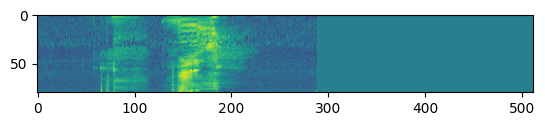

In [21]:
idx = 1
sample = torgo_ds[idx]
S = torch.tensor(sample["in_spectrogram"]).to(device)

print(S.shape)

plt.figure()
plt.imshow(S.squeeze().detach().cpu())
plt.show()

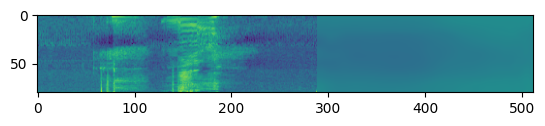

In [22]:
S_batch = torch.stack([S,S], dim=0) 
S_recon, (t_stretch,f_stretch,warp_v,warp_w,amplitude) = reconstruct_batched(S_batch, epsilon=2.0)

plt.figure() 
plt.imshow(S_recon[0].squeeze().detach().cpu()) 
plt.show()

In [23]:
for field in (t_stretch,f_stretch,warp_v,warp_w,amplitude):
    print(field.abs().mean().detach().cpu().numpy())

0.002827658
0.005269009
0.017024605
0.005091309
0.1426978


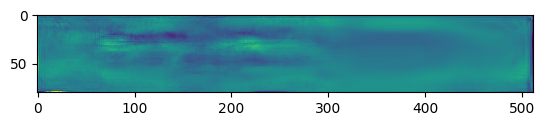

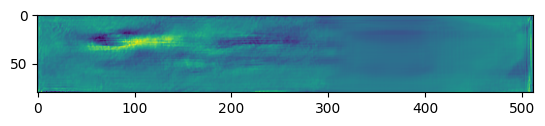

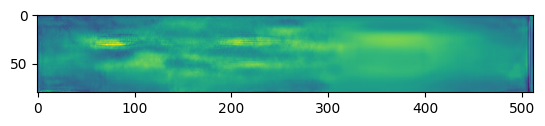

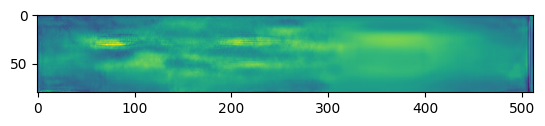

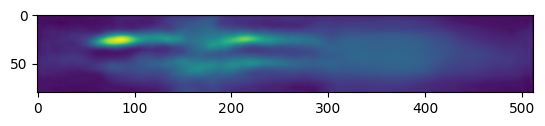

In [24]:
plt.figure() 
plt.imshow(t_stretch[0].squeeze().detach().cpu()) 
plt.show()

plt.figure() 
plt.imshow(f_stretch[0].squeeze().detach().cpu()) 
plt.show()

plt.figure() 
plt.imshow(warp_v[0].squeeze().detach().cpu()) 
plt.show()

plt.figure() 
plt.imshow(warp_v[1].squeeze().detach().cpu()) 
plt.show()

plt.figure() 
plt.imshow(amplitude[0].squeeze().detach().cpu()) 
plt.show()

In [25]:
def normalize_text(text):
    """Standardize text (lowercase, remove punctuation, trim spaces)"""
    text = text.lower().strip()
    text = re.sub(r"[^\w\s]", "", text)  # Remove punctuation
    return text

In [26]:
def compute_per(ref_phonemes, hyp_phonemes):
    """
    Compute the Phoneme Error Rate (PER) between two phoneme sequences.

    Args:
        ref_phonemes (list): Reference list of phonemes.
        hyp_phonemes (list): Hypothesis list of phonemes.

    Returns:
        float: PER value.
    """
    # Initialize a (len(ref)+1) x (len(hyp)+1) matrix
    m = len(ref_phonemes)
    n = len(hyp_phonemes)
    dp = [[0] * (n + 1) for _ in range(m + 1)]

    # Initialize the first row and column
    for i in range(m + 1):
        dp[i][0] = i
    for j in range(n + 1):
        dp[0][j] = j

    # Populate the matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref_phonemes[i - 1] == hyp_phonemes[j - 1]:
                dp[i][j] = dp[i - 1][j - 1]
            else:
                substitution = dp[i - 1][j - 1] + 1
                insertion = dp[i][j - 1] + 1
                deletion = dp[i - 1][j] + 1
                dp[i][j] = min(substitution, insertion, deletion)

    # PER = (Substitutions + Insertions + Deletions) / Number of reference phonemes
    per = dp[m][n] / max(m, 1)  # Avoid division by zero

    return per


In [27]:
# def preprocess_commonvoice(sample):
#     wf = sample['audio']['array']
#     S = processor.preprocess_nemo_single(wf)
#     S = S.squeeze(0)
#     sample['in_spectrogram'] = S
#     return sample
    

# commonvoice_ds = load_dataset('miosipof/CommonVoice_EN_min',split="train")
# commonvoice_ds.rename_column('sentence','transcription')

# len_ds = len(commonvoice_ds)
# commonvoice_ds = commonvoice_ds.select(range(len_ds-5000,len_ds))
# commonvoice_ds.add_column('in_spectrogram',len(commonvoice_ds)*[0])

# commonvoice_ds = commonvoice_ds.map(preprocess_commonvoice)



In [28]:
# create_repo('miosipof/CommonVoice_STS_EN_min', repo_type="dataset")
# commonvoice_ds.push_to_hub('miosipof/CommonVoice_STS_EN_min',split="train")

In [29]:
# def preprocess_uaspeech(sample):
#     wf = sample['speech']
#     S = processor.preprocess_nemo_single(wf)
#     S = S.squeeze(0)
#     sample['in_spectrogram'] = S
#     return sample


# uaspeech_ds = load_dataset('ngdiana/uaspeech_severity_high',split="train")
# uaspeech_ds = uaspeech_ds.rename_column('target','transcription')
# uaspeech_ds = uaspeech_ds.select(range(5000))

# uaspeech_ds.add_column('in_spectrogram',len(uaspeech_ds)*[0])
# uaspeech_ds = uaspeech_ds.map(preprocess_uaspeech)

In [30]:
# create_repo('miosipof/uaspeech_min', repo_type="dataset")

# uaspeech_ds.push_to_hub('miosipof/uaspeech_min',split="train")

In [31]:
torgo_ds = asr_datasets['train'].select(range(5000))

In [32]:
uaspeech_ds = load_dataset('miosipof/uaspeech_min',split="train")
uaspeech_ds = uaspeech_ds.rename_column('target','transcription')

# uaspeech_ds = load_dataset('miosipof/StS_UASpeech', split="train")
# uaspeech_ds = uaspeech_ds.rename_column('target','transcription')

# uaspeech_ds_med = uaspeech_ds.filter(lambda x: x['severity'] == 'medium')
# uaspeech_ds_high = uaspeech_ds.filter(lambda x: x['severity'] == 'high')

# uaspeech_ds_med.save_to_disk("uaspeech_ds_med.hf")
# uaspeech_ds_high.save_to_disk("uaspeech_ds_high.hf")

# uaspeech_ds_med = load_from_disk("uaspeech_ds_med.hf")
# uaspeech_ds_high = load_from_disk("uaspeech_ds_high.hf")

# print(len(uaspeech_ds_med), len(uaspeech_ds_high))

In [33]:
commonvoice_ds = load_dataset('miosipof/CommonVoice_STS_EN_min',split="train")
commonvoice_ds = commonvoice_ds.rename_column('sentence','transcription')


In [34]:
# eval_dataset = asr_datasets["train"].shuffle() #.select(range(1000))
# text_column_name = 'transcription'

# eval_dataset = datasets["train"].select(range(500))
# text_column_name = 'sentence'

In [35]:
import epitran

epi = epitran.Epitran('eng-Latn')
epi.transliterate("i want to eat")

'aj wɑnt tə it'

In [44]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import re
import math


def run_inference(model,asr_model,eval_dataset,eps=1.0,batch_size=2,text_column_name = 'transcription',random=False):

    model.eval()
    asr_model.eval()
    
    metric = evaluate_lib.load("wer")
    cer_metric = evaluate_lib.load("cer")
    
    in_wers = []
    in_cers = []
    in_status = []
    in_texts = []
    in_pers = []
    in_scores = []
    new_wers = []
    new_cers = []
    new_status = []
    new_texts = []
    new_pers = []
    new_scores = []
    refs = []

    if random == True:
        batch_size = 1
        
    num_batches = len(eval_dataset)//batch_size


    
    with torch.no_grad():
        for j in range(num_batches-1):


            if batch_size > 1:
                batch = eval_dataset.select(range(j*batch_size, (j+1)*batch_size))
            else:
                batch = [eval_dataset[j]]


            # if len(batch[0]['speech']) < 85000:
            #     continue
                
            reference_texts = [sample[text_column_name] for sample in batch]
            reference_texts = [normalize_text(reference_text) for reference_text in reference_texts]

            S_len = len(batch[0]["in_spectrogram"][0])

            
            S_batch = [torch.tensor(sample["in_spectrogram"]).to(device) for sample in batch]
            S_batch = [processor.pad_spectrogram(S.unsqueeze(0)).squeeze(0) for S in S_batch]
            S_batch = torch.stack(S_batch, dim=0)

    
            in_hypotheses = predict(S_batch[:,:,:S_len].squeeze(1).to(device))
            in_pred = [normalize_text(hyp.text) for hyp in in_hypotheses]


            wer_in = []
            cer_in = []
            per_in = []
            for i, text in enumerate(reference_texts):
                wer_in.append(metric.compute(references=[text], predictions=[in_pred[i]]))
                cer_in.append(cer_metric.compute(references=[text], predictions=[in_pred[i]]))

                in_ph = epi.transliterate(in_pred[i])
                ref_ph = epi.transliterate(text)
                per = compute_per(ref_ph,in_ph)
                per_in.append(per)
            
            # threshold = 0.5 # apply strong transformations only for samples with WER > threshold
            # eps_max = 3.0
            # b = 2.0
            # dynamic_epsilon = eps_max * torch.sigmoid(b * (wer_in - torch.tensor(threshold)))
    
            dynamic_epsilon = eps

            if random == False:
                # /start RECONSTRUCT WITH MODEL
                S_recon, fields = reconstruct_batched(S_batch,epsilon=dynamic_epsilon)
                S_recon = S_recon.squeeze(1) # Get rid of the channel dim 
                # S_recon = sharpen(S_recon, alpha=0.5)
                # /end RECONSTRUCT WITH MODEL
                
            else:
                # /start RECONSTRUCT WITH RANDOM WARPS
                # epsilon_dict = {
                #     't_stretch': eps/2,
                #     'f_stretch': eps,
                #     'warp_2d': eps,
                #     'amplitude': eps/5,
                #     'phase': eps,
                # }    
                epsilon_dict = {
                    't_stretch': 0*eps/2,
                    'f_stretch': 0*eps,
                    'warp_2d': 0*eps,
                    'amplitude': 1*eps/5,
                    'phase': 0*eps,
                }                    
                S_single = S_batch.squeeze(0)
                random_fields = generate_lie_generator_fields(S_single.shape[-2], S_single.shape[-1], epsilon_dict=epsilon_dict, device=device)
                pred_fields = [None] * 5
                pred_fields[0] = random_fields['t_stretch']
                pred_fields[1] = random_fields['f_stretch']
                pred_fields[2] = random_fields['warp_2d'][0]
                pred_fields[3] = random_fields['warp_2d'][1]
                pred_fields[4] = random_fields['amplitude']     
                pred_fields = torch.stack(pred_fields,dim=0).unsqueeze(0) # B,C, F, T
                S_batch = S_batch.unsqueeze(0) # add channel dim            
                S_padded = pad_spectrogram(S_batch)            
                S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)   
                S_recon, fields = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)          
                S_recon = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)
                # /end RECONSTRUCT WITH RANDOM WARPS

            (t_stretch,f_stretch,warp_v,warp_w,amplitude) = fields
            field_norms = [field.abs().mean() for field in fields]
            
            new_hypotheses = predict(S_recon[:,:,:S_len].to(device))
            new_pred = [normalize_text(hyp.text) for hyp in new_hypotheses]
            
            wer_new = []
            cer_new = []
            per_new = []
            for i, text in enumerate(reference_texts):
                wer_new.append(metric.compute(references=[text], predictions=[new_pred[i]]))
                cer_new.append(cer_metric.compute(references=[text], predictions=[new_pred[i]]))
                
                new_ph = epi.transliterate(new_pred[i])
                ref_ph = epi.transliterate(text)
                per = compute_per(ref_ph,new_ph)
                per_new.append(per)

            
    
            in_wers.extend(wer_in)
            in_cers.extend(cer_in)
            in_pers.extend(per_in)
            in_texts.extend(in_pred)

            new_wers.extend(wer_new)
            new_cers.extend(cer_new)
            new_pers.extend(per_new)
            new_texts.extend(new_pred)
            
            
            refs.extend(reference_texts)
            
            if batch_size == 1:
                in_stat = 0 if in_hypotheses[0].text == '' else 1
                new_stat = 0 if new_hypotheses[0].text == '' else 1
        
                in_status.append(in_stat)
                new_status.append(new_stat)
    
            # if wer_in[0] < 1.0 and per_new[0] > per_in[0]*1.2 and in_pred[0] != '' and new_pred[0] != '':

            #     print(f"WER: {wer_in[i]*100:.2f}%-->{wer_new[i]*100:.2f}%")
            #     print(f"CER: {cer_in[i]*100:.2f}%-->{cer_new[i]*100:.2f}%")
            #     print(f"PER: {per_in[i]*100:.2f}%-->{per_new[i]*100:.2f}%")
          
            #     print(f"TRUE: {reference_texts[i]}")
            #     print(f"BASE: {in_hypotheses[i].text}")
            #     print(f"_NEW: {new_hypotheses[i].text}")
                
            #     plt.figure() 
            #     plt.imshow(S_batch[0].squeeze().detach().cpu()) 
            #     plt.show()                      
            #     plt.figure() 
            #     plt.imshow(S_recon[0].squeeze().detach().cpu()) 
            #     plt.show()                
            #     plt.figure() 
            #     plt.imshow(t_stretch[0].squeeze().detach().cpu()) 
            #     plt.show()                
            #     plt.figure() 
            #     plt.imshow(f_stretch[0].squeeze().detach().cpu()) 
            #     plt.show() 
            #     plt.figure() 
            #     plt.imshow(warp_v[0].squeeze().detach().cpu()) 
            #     plt.show() 
            #     plt.figure() 
            #     plt.imshow(warp_w[0].squeeze().detach().cpu()) 
            #     plt.show() 
            #     plt.figure() 
            #     plt.imshow(amplitude[0].squeeze().detach().cpu()) 
            #     plt.show() 

            if j%100 == 0:
                for i, sample in enumerate(batch):
                    print(f"Batch {j}/{num_batches}, sample {i}")
                    print(f"WER: {wer_in[i]*100:.2f}%-->{wer_new[i]*100:.2f}%")
                    print(f"CER: {cer_in[i]*100:.2f}%-->{cer_new[i]*100:.2f}%")
                    print(f"PER: {per_in[i]*100:.2f}%-->{per_new[i]*100:.2f}%")
              
                    print(f"TRUE: {reference_texts[i]}")
                    print(f"BASE: {in_hypotheses[i].text}")
                    print(f"_NEW: {new_hypotheses[i].text}")
        
                    print(f"Eps: {dynamic_epsilon:.2f}")

                    print("t_stretch:",field_norms[0])
                    print("f_stretch:",field_norms[1])
                    print("warp2d_v:",field_norms[2])
                    print("warp2d_w:",field_norms[3])
                    print("amplitude:",field_norms[4])
            
                    print("\n")


    result = {
    'in_wers': in_wers,
    'in_cers': in_cers,
    'in_pers': in_pers,
    'in_status': in_status,
    'in_texts': in_texts,
    'new_wers': new_wers,
    'new_cers': new_cers,
    'new_pers': new_pers,
    'new_status': new_status,
    'new_texts': new_texts,
    'refs': refs
    }

    return result
    

In [ ]:
# torgo_ds
# uaspeech_ds

result = run_inference(model,asr_model,commonvoice_ds,eps=0.6,batch_size=1,random=False)

Batch 0/5000, sample 0
WER: 0.00%-->0.00%
CER: 0.00%-->0.00%
PER: 0.00%-->0.00%
TRUE: in the victorian era this was a radical notion
BASE: in the victorian era this was a radical notion
_NEW: in the victorian era this was a radical notion
Eps: 0.60
t_stretch: tensor(0.0004, device='cuda:0')
f_stretch: tensor(0.0005, device='cuda:0')
warp2d_v: tensor(0.0006, device='cuda:0')
warp2d_w: tensor(0.0004, device='cuda:0')
amplitude: tensor(0.0301, device='cuda:0')




In [ ]:
import pandas as pd


if len(result['in_status']) == 0:
    del result['in_status']
    del result['new_status']

    
resulf_df = pd.DataFrame.from_dict(result)
# resulf_df.to_csv("Lie_Random_UASPEECH.csv")
resulf_df.to_csv("Lie_ResNet_ssb_v4_CommonVoice.csv")

print("Results saved to CSV")

In [43]:
sample = torgo_ds[1435]

print(sample['transcription'])
wf = sample['audio']['array']

import IPython.display as ipd
ipd.display(ipd.Audio(wf, rate=sampling_rate))

usually minus several buttons


In [29]:
# import pandas as pd

# result_df = pd.read_csv('Lie_Random_UASPEECH.csv')
# result = result_df.to_dict()
# res = {}
# for k,v in result.items():
#     v = list(v.values())
#     res[k] = v

# result = res

In [ ]:
def word_count(text: str) -> int:
    """Count how many words in `text`, splitting on whitespace."""
    return len(text.split())

def char_count(text: str) -> int:
    """Count total characters, ignoring spaces if you want (optional)."""
    # If ignoring spaces:
    text_no_spaces = text.replace(" ", "")
    return len(text_no_spaces)


In [ ]:
import numpy as np

refs = result['refs']  # e.g. list of reference strings
n_samples = len(refs)

word_counts = [word_count(r) for r in refs]  # e.g. [3, 5, 6, ...]
char_counts = [char_count(r) for r in refs]  # e.g. [15, 23, ...]

total_words = sum(word_counts)
total_chars = sum(char_counts)


in_wers = result['in_wers']   # shape [n_samples]
new_wers = result['new_wers']

in_errors_word = 0.0
new_errors_word = 0.0

for i in range(n_samples):
    in_errors_word += in_wers[i] * word_counts[i]
    new_errors_word += new_wers[i] * word_counts[i]


in_cers = result['in_cers']
new_cers = result['new_cers']

in_pers = result['in_pers']
new_pers = result['new_pers']

in_errors_char = 0.0
new_errors_char = 0.0

for i in range(n_samples):
    in_errors_char += in_cers[i] * char_counts[i]
    new_errors_char += new_cers[i] * char_counts[i]


wer_in_global = in_errors_word / (total_words if total_words > 0 else 1)
wer_new_global = new_errors_word / (total_words if total_words > 0 else 1)

print(f"BASE global WER: {wer_in_global:.3f}")
print(f"NEW global WER: {wer_new_global:.3f}")

cer_in_global = in_errors_char / (total_chars if total_chars > 0 else 1)
cer_new_global = new_errors_char / (total_chars if total_chars > 0 else 1)

print(f"In system global CER: {cer_in_global:.3f}")
print(f"New system global CER: {cer_new_global:.3f}")



In [ ]:
improvements = resulf_df[resulf_df['new_wers'] < resulf_df['in_wers']]

for i,row in improvements.iterrows():
    if row['new_texts'] != '':
        print(f"TRUE: {row['refs']}")
        print(f"BASE: {row['in_texts']}")
        print(f"PRED: {row['new_texts']}\n\n")

In [58]:
from scipy.stats import ttest_rel, wilcoxon


print(f"WER: {np.mean(result['in_wers'])}-->{np.mean(result['new_wers'])}")
print(f"CER: {np.mean(result['in_cers'])}-->{np.mean(result['new_cers'])}")
print(f"PER: {np.mean(result['in_pers'])}-->{np.mean(result['new_pers'])}")

print(f"Median WER: {np.median(result['in_wers'])}-->{np.median(result['new_wers'])}")
print(f"Median CER: {np.median(result['in_cers'])}-->{np.median(result['new_cers'])}")
print(f"Median PER: {np.median(result['in_pers'])}-->{np.median(result['new_pers'])}")

_, p_wer = ttest_rel(result['in_wers'], result['new_wers'])
_, p_cer = ttest_rel(result['in_cers'], result['new_cers'])
_, p_per = ttest_rel(result['in_pers'], result['new_pers'])

print(f"WER p-value: {p_wer}, CER p-value: {p_cer}, PER p-value: {p_per}")



print(f"WER variance: {np.std(result['in_wers'])}-->{np.std(result['new_wers'])}")
print(f"CER variance: {np.std(result['in_cers'])}-->{np.std(result['new_cers'])}")
print(f"PER variance: {np.std(result['in_pers'])}-->{np.std(result['new_pers'])}")


WER: 0.772557447997536-->0.7225112932454401
CER: 0.6310206903875417-->0.5758521202557155
PER: 0.6096615071950218-->0.537815394610273
Median WER: 1.0-->1.0
Median CER: 0.6666666666666666-->0.6666666666666666
Median PER: 0.6388888888888888-->0.6
WER p-value: 6.602447518401165e-12, CER p-value: 4.5682909866700986e-14, PER p-value: 1.2711482700430663e-21
WER variance: 0.6024182763141337-->0.5088564073631503
CER variance: 0.5449395737821705-->0.44907759522158525
PER variance: 0.570558311363157-->0.45121010771524367


In [180]:
improved = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] < result['in_wers'][i])
worsened = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] > result['in_wers'][i])
same = sum(1 for i in range(len(result['in_wers'])) if result['new_wers'][i] == result['in_wers'][i])

net_gain = improved - worsened
print(f"Improved: {improved}, Worsened: {worsened}, Net gain: {net_gain}")

improved_value = sum([result['in_wers'][i] - result['new_wers'][i] for i in range(len(result['in_wers'])) if result['new_wers'][i] < result['in_wers'][i]])
worsened_value = sum([result['in_wers'][i] - result['new_wers'][i] for i in range(len(result['in_wers'])) if result['new_wers'][i] > result['in_wers'][i]])

print(f"Improved value: {improved_value:.4f}, Worsened value: {worsened_value:.4f}, Net gain value: {improved_value + worsened_value:.4f}")

Improved: 85, Worsened: 42, Net gain: 43
Improved value: 76.3135, Worsened value: -33.6479, Net gain value: 42.6656


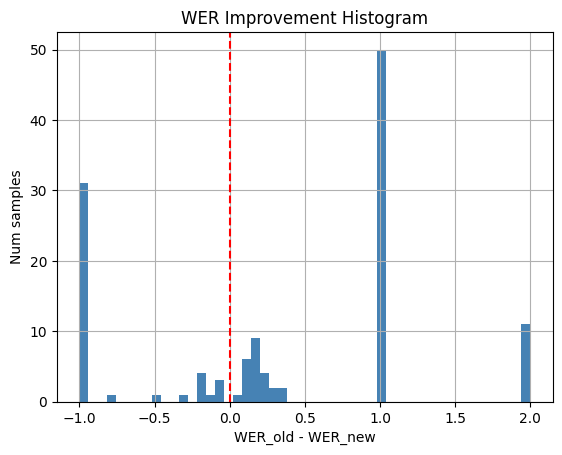

In [181]:
import matplotlib.pyplot as plt
deltas = [old - new for old, new in zip(result['in_wers'], result['new_wers']) if old != new]

plt.hist(deltas, bins=50, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("WER Improvement Histogram")
plt.xlabel("WER_old - WER_new")
plt.ylabel("Num samples")
plt.grid(True)
plt.show()

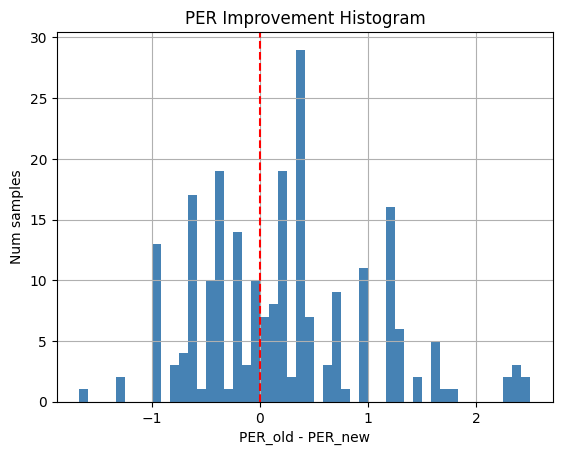

In [182]:
import matplotlib.pyplot as plt
deltas = [old - new for old, new in zip(result['in_pers'], result['new_pers']) if old != new]

plt.hist(deltas, bins=50, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--')
plt.title("PER Improvement Histogram")
plt.xlabel("PER_old - PER_new")
plt.ylabel("Num samples")
plt.grid(True)
plt.show()

In [59]:
threshold = 0.99
wrong_base = {i for i, w in enumerate(result['in_wers']) if w > threshold}
wrong_new = {i for i, w in enumerate(result['new_wers']) if w > threshold}

fixed_by_model = wrong_base - wrong_new
broken_by_model = wrong_new - wrong_base
print(f"Fixed: {len(fixed_by_model)}, New errors: {len(broken_by_model)}")



Fixed: 87, New errors: 79


In [183]:
print("\nWER filtered (only samples with both new and old WER < 300%):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(in_wers):
    if result['in_wers'][i] < 3.0 and result['new_wers'][i] < 3.0:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print("\nCER filtered (only samples with both new and old CER < 200%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if result['in_cers'][i] < 2.0 and result['new_cers'][i] < 2.0:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with both new and old WER < 300%):
WER (494 samples): 0.7751173927287287-->0.7069684588915358

CER filtered (only samples with both new and old CER < 200%):
CER (481 samples): 0.6031402214095929-->0.5648736111791433


In [184]:
# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)

print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}")

Filtered WER p-value: 0.0012757598969708275, Filtered CER p-value: 0.04604780320819382


In [59]:
wer_treshold = 0.5
cer_treshold = 0.3
per_treshold = 0.3

print(f"\nWER filtered (only samples with old WER > {wer_treshold*100}%):")

in_wers_filtered = []
new_wers_filtered = []
in_scores_filtered = []
new_scores_filtered = []
for i, w in enumerate(in_wers):
    if result['in_wers'][i] > wer_treshold:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])


print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")


print(f"\nCER filtered (only samples with old CER > {cer_treshold*100}%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(in_cers):
    if result['in_cers'][i] > cer_treshold:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}\n")


print(f"\nPER filtered (only samples with old PER > {per_treshold*100}%):")

in_pers_filtered = []
new_pers_filtered = []
for i, p in enumerate(in_pers):
    if result['in_cers'][i] > per_treshold:
        in_pers_filtered.append(result['in_pers'][i])
        new_pers_filtered.append(result['new_pers'][i])

print(f"PER ({len(in_pers_filtered)} samples): {np.mean(in_pers_filtered)}-->{np.mean(new_pers_filtered)}\n")

# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)
_, p_per = ttest_rel(in_pers_filtered, new_pers_filtered)


print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}, Filtered PER p-value: {p_per}")


WER filtered (only samples with old WER > 50.0%):
WER (3405 samples): 1.1015781444856334-->0.9243888637060443

CER filtered (only samples with old CER > 30.0%):
CER (3386 samples): 0.9107438128153273-->0.7365650967771077


PER filtered (only samples with old PER > 30.0%):
PER (3386 samples): 0.8784995558715111-->0.690598514092077

Filtered WER p-value: 2.088287492424913e-89, Filtered CER p-value: 1.9282486343558075e-77, Filtered PER p-value: 2.2109962579957784e-80


In [60]:
cleaned_results = resulf_df[resulf_df['in_status'] == 1]
cleaned_results = cleaned_results[cleaned_results['new_status'] == 1]

len(cleaned_results)

print(f"WER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_wers'])}-->{np.mean(cleaned_results['new_wers'])}")
print(f"CER ({len(cleaned_results)} cleaned samples): \n{np.mean(cleaned_results['in_cers'])}-->{np.mean(cleaned_results['new_cers'])}")

_, p_wer = ttest_rel(cleaned_results['in_wers'], cleaned_results['new_wers'])
_, p_cer = ttest_rel(cleaned_results['in_cers'], cleaned_results['new_cers'])

print(f"Cleaned WER p-value: {p_wer} \nCleaned CER p-value: {p_cer}")

WER (3975 cleaned samples): 
0.7299099530797644-->0.6564781437988985
CER (3975 cleaned samples): 
0.567541967445476-->0.488455352910297
Cleaned WER p-value: 2.072969298973197e-18 
Cleaned CER p-value: 2.7084169577165684e-21


In [25]:
# whisper_model_id = "openai/whisper-medium"
whisper_model_id = "nyrahealth/CrisperWhisper"
whisper = WhisperForConditionalGeneration.from_pretrained(whisper_model_id).to(device)
whisper_processor = WhisperProcessor.from_pretrained(whisper_model_id, language="en", task="transcribe")


In [26]:
import torch.nn.functional as F

def upsample_to_128_mel(S_batch_80):
    """
    Upsample 80-mel spectrograms to 128-mel bins using bilinear interpolation.
    Input: [B, 80, T]
    Output: [B, 128, T]
    """
    B, Freq, Time = S_batch_80.shape
    S_expanded = S_batch_80.unsqueeze(1)
    S_upsampled = F.interpolate(S_expanded, size=(128, Time), mode='bilinear', align_corners=True)
    S_upsampled = S_upsampled.squeeze(1)
    return S_upsampled


# def downsample_128_to_80_mel(S_batch_128):
#     """
#     Downsample 128-mel spectrograms to 80-mel bins using bilinear interpolation.
#     Input: [B, 1, 128, T]
#     Output: [B, 1, 80, T]
#     """
#     B, C, F, T = S_batch_128.shape
#     S_downsampled = F.interpolate(S_batch_128, size=(80, T), mode='bilinear', align_corners=True)
#     return S_downsampled

In [27]:
def predict_whisper(S):
    
        S = S.to(device)

        forced_decoder_ids = whisper_processor.get_decoder_prompt_ids(language="en", task="transcribe")
    
        generated_ids = whisper.generate(
            S,
            do_sample=False,           # Deterministic decoding
            num_beams=1,               # Beam search with 1 beams
            temperature=0.0,           # No randomness
            top_k=1,                   # Only top token allowed
            top_p=1.0,                 # No nucleus sampling
            repetition_penalty=1.2,    # Penalize repeated outputs
            length_penalty=1.0,        # Balanced output length
            forced_decoder_ids=forced_decoder_ids,  # Force language/token
        )

        pred_text = whisper_processor.batch_decode(generated_ids, skip_special_tokens=True)
    
        # Normalize both reference and predicted text
        pred_texts = [normalize_text(txt) for txt in pred_text]

        return pred_texts

In [28]:
from model import Processor
whisper_preprocessor = Processor(asr_model=whisper_processor, device=device)

In [32]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import torch.nn.functional as F
import re


import math


def run_inference_whisper(model,asr_model,eval_dataset,eps=1.0,batch_size=2,text_column_name = 'transcription',random=False):

    model.eval()
    asr_model.eval()
    
    metric = evaluate_lib.load("wer")
    cer_metric = evaluate_lib.load("cer")
    
    in_wers = []
    in_cers = []
    in_status = []
    in_texts = []
    in_pers = []
    in_scores = []
    new_wers = []
    new_cers = []
    new_status = []
    new_texts = []
    new_pers = []
    new_scores = []
    refs = []

    if random == True:
        batch_size = 1
        
    num_batches = len(eval_dataset)//batch_size


    
    with torch.no_grad():
        for j in range(num_batches-1):

            if batch_size > 1:
                batch = eval_dataset.select(range(j*batch_size, (j+1)*batch_size))
            else:
                batch = [eval_dataset[j]]
    
            reference_texts = [sample[text_column_name] for sample in batch]
            reference_texts = [normalize_text(reference_text) for reference_text in reference_texts]
            
            S_batch = [torch.tensor(sample["in_spectrogram"]).to(device) for sample in batch]
            S_batch = [whisper_preprocessor.pad_spectrogram(S.unsqueeze(0)).squeeze(0) for S in S_batch]
            S_batch = torch.stack(S_batch, dim=0)


            
            
            # threshold = 0.5 # apply strong transformations only for samples with WER > threshold
            # eps_max = 3.0
            # b = 2.0
            # dynamic_epsilon = eps_max * torch.sigmoid(b * (wer_in - torch.tensor(threshold)))
    
            dynamic_epsilon = eps

            if random == False:
                # /start RECONSTRUCT WITH MODEL
                S_recon, fields = reconstruct_batched(S_batch,epsilon=dynamic_epsilon)
                S_recon = S_recon.squeeze(1) # Get rid of the channel dim 
                # S_recon = sharpen(S_recon, alpha=0.5)
                # /end RECONSTRUCT WITH MODEL
                
            else:
                # /start RECONSTRUCT WITH RANDOM WARPS
                # epsilon_dict = {
                #     't_stretch': eps/2,
                #     'f_stretch': eps,
                #     'warp_2d': eps,
                #     'amplitude': eps/5,
                #     'phase': eps,
                # }    
                epsilon_dict = {
                    't_stretch': 0*eps/2,
                    'f_stretch': 0*eps,
                    'warp_2d': 0*eps,
                    'amplitude': 1*eps/5,
                    'phase': 0*eps,
                }                    
                S_single = S_batch.squeeze(0)
                random_fields = generate_lie_generator_fields(S_single.shape[-2], S_single.shape[-1], epsilon_dict=epsilon_dict, device=device)
                pred_fields = [None] * 5
                pred_fields[0] = random_fields['t_stretch']
                pred_fields[1] = random_fields['f_stretch']
                pred_fields[2] = random_fields['warp_2d'][0]
                pred_fields[3] = random_fields['warp_2d'][1]
                pred_fields[4] = random_fields['amplitude']     
                pred_fields = torch.stack(pred_fields,dim=0).unsqueeze(0) # B,C, F, T
                S_batch = S_batch.unsqueeze(0) # add channel dim            
                S_padded = pad_spectrogram(S_batch)            
                S_norm = normalize_spectrogram(S_padded, min_val=-7.0, max_val=1.0)   
                S_recon, fields = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)          
                S_recon = denormalize_spectrogram(S_recon, min_val=-7.0, max_val=1.0)
                # /end RECONSTRUCT WITH RANDOM WARPS

            (t_stretch,f_stretch,warp_v,warp_w,amplitude) = fields
            field_norms = [field.abs().mean() for field in fields]


            S_in_128 = upsample_to_128_mel(S_batch)
            in_pred = predict_whisper(S_in_128)

            S_recon_128 = upsample_to_128_mel(S_recon)
            new_pred = predict_whisper(S_recon_128)

            wer_in = []
            cer_in = []
            per_in = []
            for i, text in enumerate(reference_texts):
                wer_in.append(metric.compute(references=[text], predictions=[in_pred[i]]))
                cer_in.append(cer_metric.compute(references=[text], predictions=[in_pred[i]]))

                in_ph = epi.transliterate(in_pred[i])
                ref_ph = epi.transliterate(text)
                per = compute_per(ref_ph,in_ph)
                per_in.append(per)


            
            wer_new = []
            cer_new = []
            per_new = []
            for i, text in enumerate(reference_texts):
                wer_new.append(metric.compute(references=[text], predictions=[new_pred[i]]))
                cer_new.append(cer_metric.compute(references=[text], predictions=[new_pred[i]]))
                
                new_ph = epi.transliterate(new_pred[i])
                ref_ph = epi.transliterate(text)
                per = compute_per(ref_ph,new_ph)
                per_new.append(per)

                

                
    
            in_wers.extend(wer_in)
            in_cers.extend(cer_in)
            in_pers.extend(per_in)
            in_texts.extend(in_pred)

            new_wers.extend(wer_new)
            new_cers.extend(cer_new)
            new_pers.extend(per_new)
            new_texts.extend(new_pred)
            
            
            refs.extend(reference_texts)
            
            # if batch_size == 1:
            #     in_stat = 0 if in_hypotheses[0].text == '' else 1
            #     new_stat = 0 if new_hypotheses[0].text == '' else 1
        
            #     in_status.append(in_stat)
            #     new_status.append(new_stat)
    
            if j%10 == 0:
                # plt.figure() 
                # plt.imshow(S_single.squeeze().detach().cpu()) 
                # plt.show()                      
                # plt.figure() 
                # plt.imshow(S_recon[0].squeeze().detach().cpu()) 
                # plt.show()                
                # plt.figure() 
                # plt.imshow(t_stretch[0].squeeze().detach().cpu()) 
                # plt.show()                
                # plt.figure() 
                # plt.imshow(f_stretch[0].squeeze().detach().cpu()) 
                # plt.show() 
                # plt.figure() 
                # plt.imshow(warp_v[0].squeeze().detach().cpu()) 
                # plt.show() 
                # plt.figure() 
                # plt.imshow(warp_w[0].squeeze().detach().cpu()) 
                # plt.show() 
                # plt.figure() 
                # plt.imshow(amplitude[0].squeeze().detach().cpu()) 
                # plt.show()                 
                for i, sample in enumerate(batch):
                    print(f"Batch {j}/{num_batches}, sample {i}")
                    print(f"WER: {wer_in[i]*100:.2f}%-->{wer_new[i]*100:.2f}%")
                    print(f"CER: {cer_in[i]*100:.2f}%-->{cer_new[i]*100:.2f}%")
                    print(f"PER: {per_in[i]*100:.2f}%-->{per_new[i]*100:.2f}%")
              
                    print(f"TRUE: {reference_texts[i]}")
                    print(f"BASE: {in_pred[i]}")
                    print(f"_NEW: {new_pred[i]}")
        
                    print(f"Eps: {dynamic_epsilon:.2f}")

                    print("t_stretch:",field_norms[0])
                    print("f_stretch:",field_norms[1])
                    print("warp2d_v:",field_norms[2])
                    print("warp2d_w:",field_norms[3])
                    print("amplitude:",field_norms[4])
            
                    print("\n")


    result = {
    'in_wers': in_wers,
    'in_cers': in_cers,
    'in_pers': in_pers,
    'in_status': in_status,
    'in_texts': in_texts,
    'new_wers': new_wers,
    'new_cers': new_cers,
    'new_pers': new_pers,
    'new_status': new_status,
    'new_texts': new_texts,
    'refs': refs
    }

    return result
    

In [62]:
result = run_inference_whisper(model,whisper,commonvoice_ds,eps=3.0,batch_size=10,random=False)

NameError: name 'run_inference_whisper' is not defined

In [81]:
import pandas as pd

del result['in_scores']
del result['new_scores']
del result['in_status']
del result['new_status']

whisper_result_df = pd.DataFrame.from_dict(result)

In [82]:
whisper_result_df.to_csv('Lie_ResNet_ssb_v4_CommonVoice_CWhisper.csv')

In [83]:
max_text_length = 1000


print(f"\nWER filtered (only samples with len(pred_texts) < {max_text_length}):")

in_wers_filtered = []
new_wers_filtered = []
for i, w in enumerate(result['in_wers']):
    if len(result['in_texts'][i]) < max_text_length and len(result['new_texts'][i]) < max_text_length:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")



print(f"\nCER filtered (only samples with len(pred_texts) < {max_text_length}):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(result['in_cers']):
    if len(result['in_texts'][i]) < max_text_length and len(result['new_texts'][i]) < max_text_length:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}")


WER filtered (only samples with len(pred_texts) < 1000):
WER (4990 samples): 0.4550390330973813-->0.3518247153753204

CER filtered (only samples with len(pred_texts) < 1000):
CER (4990 samples): 0.34838655299884436-->0.26457365425971746


In [84]:
from scipy.stats import ttest_rel, wilcoxon


print(f"WER: {np.mean(result['in_wers'])}-->{np.mean(result['new_wers'])}")
print(f"CER: {np.mean(result['in_cers'])}-->{np.mean(result['new_cers'])}")
print(f"PER: {np.mean(result['in_pers'])}-->{np.mean(result['new_pers'])}")

# print(f"Median WER: {np.median(result['in_wers'])}-->{np.median(result['new_wers'])}")
# print(f"Median CER: {np.median(result['in_cers'])}-->{np.median(result['new_cers'])}")
# print(f"Median PER: {np.median(result['in_pers'])}-->{np.median(result['new_pers'])}")

_, p_wer = ttest_rel(result['in_wers'], result['new_wers'])
_, p_cer = ttest_rel(result['in_cers'], result['new_cers'])
_, p_per = ttest_rel(result['in_pers'], result['new_pers'])

print(f"WER p-value: {p_wer}, CER p-value: {p_cer}, PER p-value: {p_per}")



print(f"WER variance: {np.std(result['in_wers'])}-->{np.std(result['new_wers'])}")
print(f"CER variance: {np.std(result['in_cers'])}-->{np.std(result['new_cers'])}")
print(f"PER variance: {np.std(result['in_pers'])}-->{np.std(result['new_pers'])}")


WER: 0.4550390330973813-->0.3518247153753204
CER: 0.34838655299884436-->0.26457365425971746
PER: 0.35893120795073374-->0.2718413765094356
WER p-value: 3.1040518145703406e-148, CER p-value: 3.355112519729805e-127, PER p-value: 4.327813433202942e-130
WER variance: 0.35581265178237925-->0.32254076559513983
CER variance: 0.3243105502247883-->0.2927769287753611
PER variance: 0.3312118578765914-->0.2966700603812883


In [85]:
wer_treshold = 0.5
cer_treshold = 0.3
per_treshold = 0.3

print(f"\nWER filtered (only samples with old WER > {wer_treshold*100}%):")

in_wers_filtered = []
new_wers_filtered = []
in_scores_filtered = []
new_scores_filtered = []
for i, w in enumerate(result['in_wers']):
    if result['in_wers'][i] > wer_treshold:
        in_wers_filtered.append(result['in_wers'][i])
        new_wers_filtered.append(result['new_wers'][i])

print(f"WER ({len(in_wers_filtered)} samples): {np.mean(in_wers_filtered)}-->{np.mean(new_wers_filtered)}")


print(f"\nCER filtered (only samples with old CER > {cer_treshold*100}%):")

in_cers_filtered = []
new_cers_filtered = []
for i, c in enumerate(result['in_cers']):
    if result['in_cers'][i] > cer_treshold:
        in_cers_filtered.append(result['in_cers'][i])
        new_cers_filtered.append(result['new_cers'][i])

print(f"CER ({len(in_cers_filtered)} samples): {np.mean(in_cers_filtered)}-->{np.mean(new_cers_filtered)}\n")


print(f"\nPER filtered (only samples with old PER > {per_treshold*100}%):")

in_pers_filtered = []
new_pers_filtered = []
for i, p in enumerate(result['in_pers']):
    if result['in_pers'][i] > per_treshold:
        in_pers_filtered.append(result['in_pers'][i])
        new_pers_filtered.append(result['new_pers'][i])

print(f"PER ({len(in_pers_filtered)} samples): {np.mean(in_pers_filtered)}-->{np.mean(new_pers_filtered)}\n")

# Paired t-test or Wilcoxon (non-parametric)
from scipy.stats import ttest_rel, wilcoxon

_, p_wer = ttest_rel(in_wers_filtered, new_wers_filtered)
_, p_cer = ttest_rel(in_cers_filtered, new_cers_filtered)
_, p_per = ttest_rel(in_pers_filtered, new_pers_filtered)


print(f"Filtered WER p-value: {p_wer}, Filtered CER p-value: {p_cer}, Filtered PER p-value: {p_per}")


WER filtered (only samples with old WER > 50.0%):
WER (1895 samples): 0.8522887383453113-->0.59823441531652

CER filtered (only samples with old CER > 30.0%):
CER (2249 samples): 0.6479991287741899-->0.4638560447749425


PER filtered (only samples with old PER > 30.0%):
PER (2300 samples): 0.6566284008131344-->0.4669856138557045

Filtered WER p-value: 5.505608869785202e-191, Filtered CER p-value: 1.5665944422865022e-162, Filtered PER p-value: 3.054321156226286e-171


In [52]:
def pad_spectrogram(spec, target_height=96):
    """
    Pads a spectrogram [B, 1, F, T] to height=96 (bottom-padding).
    """
    pad_height = target_height - spec.shape[2]
    return F.pad(spec, (0, 0, 0, pad_height))  # pad = (left, right, top, bottom)


def normalize_spectrogram(S, min_val=-7.0, max_val=1.0):
    """
    Normalize log-Mel spectrogram from [min_val, max_val] to [0, 1]
    Input: Tensor [F, T]
    Output: Tensor [F, T]
    """
    return (S - min_val) / (max_val - min_val)

def denormalize_spectrogram(S_norm, min_val=-7.0, max_val=1.0):
    return S_norm * (max_val - min_val) + min_val


def normalize_field(field, max_abs):
    """
    Normalize a field from [-max_abs, +max_abs] → [-1, 1]
    """
    return torch.clamp(field / max_abs, min=-1.0, max=1.0)

def denormalize_field(norm_field, max_abs):
    return norm_field * max_abs



def normalize_fields(fields, norm_ranges):
    normed_fields = {}
    for key, value in fields.items():
        if key == 'warp_2d':
            v, w = value
            v_norm = normalize_field(v, norm_ranges['warp_2d'])
            w_norm = normalize_field(w, norm_ranges['warp_2d'])
            normed_fields[key] = (v_norm, w_norm)
        else:
            normed_fields[key] = normalize_field(value, norm_ranges[key])
    return normed_fields

def denormalize_fields(normed_fields, norm_ranges):
    denormed = {}
    for key, value in normed_fields.items():
        if key == 'warp_2d':
            v_norm, w_norm = value
            v = denormalize_field(v_norm, norm_ranges['warp_2d'])
            w = denormalize_field(w_norm, norm_ranges['warp_2d'])
            denormed[key] = (v, w)
        else:
            denormed[key] = denormalize_field(value, norm_ranges[key])
    return denormed


In [108]:
def r2_score_masked(pred, target, mask=None, eps=1e-4):
    pred = pred.unsqueeze(1)
    target = target.unsqueeze(1)
    if mask is None:
        mask = torch.ones_like(target)

    masked_pred = pred * mask
    masked_target = target * mask
    numerator = ((masked_pred - masked_target) ** 2).sum(dim=(0, 1, 2, 3))
    denominator = ((masked_target - masked_target.mean(dim=(0, 1, 2, 3), keepdim=True)) ** 2).sum(dim=(0, 1, 2, 3)) + eps
    r2 = 1 - numerator / denominator
    return r2  # [C]

In [135]:
import evaluate as evaluate_lib
from jiwer import wer
import numpy as np
import torch.nn.functional as F
import re
import random
import math
from torch.utils.data import DataLoader
from model import SpectrogramAugmentDataset
from pprint import pprint as pp

def compute_meta(model,processor,dataset,epsilon=1.0,batch_size=1,text_column_name = 'transcription'):

    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    r2 = {
        't_stretch': [],
        'f_stretch': [],
        'warp_2d': [],
        'amplitude': []
    } 
    
    with torch.no_grad():
        for batch_idx, (S_new, S_in, fields, _, selected) in enumerate(dataloader): 

            transform_ids = [0,1,2,3] # [0,1,2]   
            random.shuffle(transform_ids)       
            
            dataset.random_transform_ids = transform_ids
            
            # epsilon_dict = {
            #     't_stretch': epsilon/2,
            #     'f_stretch': epsilon,
            #     'warp_2d': epsilon,
            #     'amplitude': epsilon/5,
            #     'phase': epsilon,
            # } 

            
            epsilon_dict = {
                't_stretch': 0*epsilon/2,
                'f_stretch': 0*epsilon,
                'warp_2d': 0*epsilon,
                'amplitude': 1*epsilon/5,
                'phase': 0*epsilon,
            } 
            
            S_new = S_new.unsqueeze(1) # add channel dim
            S_new_padded = pad_spectrogram(S_new)  

            S_norm = normalize_spectrogram(S_new_padded, min_val=-7.0, max_val=1.0)

            pred_fields = model(S_norm)
            pred_fields = pred_fields[:,:,:80,:]

            pred_fields_dict = {}
            pred_fields_dict['t_stretch'] = pred_fields[:,0,:,:]
            pred_fields_dict['f_stretch'] = pred_fields[:,1,:,:]
            pred_fields_dict['warp_2d'] = pred_fields[:,2,:,:]
            # pred_fields_dict['warp_2d_w'] = pred_fields[:,0,:,:]
            pred_fields_dict['amplitude'] = pred_fields[:,4,:,:]
            
            fields_norm = normalize_fields(fields,norm_ranges=epsilon_dict)
            
            true_fields = [None] * 5
            true_fields[0] = fields_norm['t_stretch']
            true_fields[1] = fields_norm['f_stretch']
            true_fields[2] = fields_norm['warp_2d'][0]
            true_fields[3] = fields_norm['warp_2d'][1]
            true_fields[4] = fields_norm['amplitude']

            true_fields = torch.stack(true_fields,dim=0) # C, B, F, T
            true_fields = true_fields.permute(1,0,2,3) # B, C, F, T

            S_recon = apply_inverse_transform(S_norm[:,:,:80,:], pred_fields, epsilon_dict=epsilon_dict)
            S_in_norm = normalize_spectrogram(S_in, min_val=-7.0, max_val=1.0) 

    
            field_norms = {k:v.abs().mean().item() for k,v in pred_fields_dict.items()}
            pp(field_norms)

            # for k in pred_fields_dict.keys():
                
            #     mask = (pred_fields_dict[k].abs() > 1e-5).float() 
            #     # print(f"Non-zero mask points: {torch.count_nonzero(mask)}")
            #     # print(mask.shape)    
                
            #     if k == 'warp_2d':                 
            #         r2_value = r2_score_masked(fields_norm[k][0], pred_fields_dict[k], mask=mask)
            #         r2[k].append(r2_value)
            #         print(f"{k}: {r2_value}")
            #     else:
            #         r2_value = r2_score_masked(fields_norm[k], pred_fields_dict[k], mask=mask)
            #         r2[k].append(r2_value)
            #         print(f"{k}: {r2_value}")
            
            # print("\n")
            

            plt.figure() 
            plt.imshow(S_in_norm[0].squeeze().detach().cpu()) 
            plt.show()      

            plt.figure() 
            plt.imshow(S_recon[0].squeeze().detach().cpu()) 
            plt.show()    

            diff_S = S_recon[0]-S_in_norm[0]
            print(f"diff_S L1 norm: {diff_S.abs().mean().item()}")
            plt.figure() 
            plt.imshow(diff_S.squeeze().detach().cpu()) 
            plt.show()   

            plt.figure() 
            plt.imshow(pred_fields_dict['t_stretch'][0].squeeze().detach().cpu()) 
            plt.show()     

            plt.figure() 
            plt.imshow(pred_fields_dict['f_stretch'][0].squeeze().detach().cpu()) 
            plt.show() 

            plt.figure() 
            plt.imshow(pred_fields_dict['warp_2d'][0].squeeze().detach().cpu()) 
            plt.show() 

            plt.figure() 
            plt.imshow(pred_fields_dict['amplitude'].squeeze().detach().cpu()) 
            plt.show() 


    return r2
    

{'amplitude': 0.23675189912319183,
 'f_stretch': 0.0008025718270801008,
 't_stretch': 0.0011757680913433433,
 'warp_2d': 0.0006538112065754831}


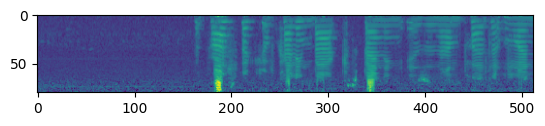

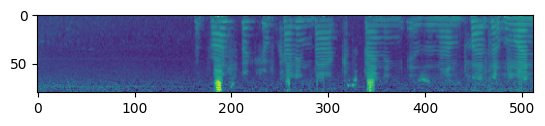

diff_S L1 norm: 0.11002855747938156


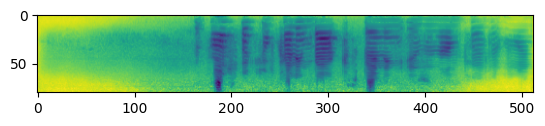

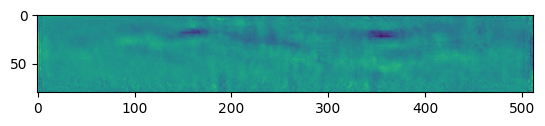

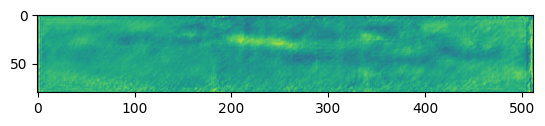

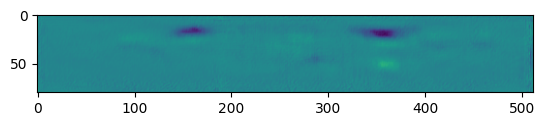

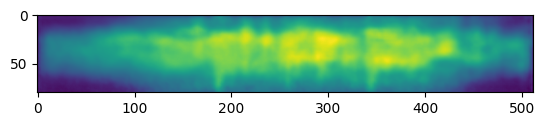

In [136]:
spec_dataset = SpectrogramAugmentDataset(processor, torgo_ds.select(range(2,3)), 20)

result_meta = compute_meta(model,processor,spec_dataset,epsilon=3.0,batch_size=1,text_column_name = 'transcription')